# 🏁 02 – Podium Prediction Model

This notebook builds a machine learning model to predict whether a Formula 1 driver will finish on the podium (Top 3) using historical race data.

We'll load, clean, and merge multiple datasets, engineer predictive features, train several classifiers, and analyze performance.


# 📓 02_podium_prediction_model.ipynb
**Version**: 1.1.0  
**Last Updated**: 2025-04-08  
**Author**: Mantas  
**Description**: Trains 3 models (RF, LR, XGB) for podium prediction and evaluates them using precision, recall, F1, confusion matrix visualizations.


📦 Load Libraries & Data

In [9]:
# -----------------------------------------------------------------------------
# 📦 Project: Formula 1 Podium Prediction
# 📓 Notebook: 02_podium_prediction_model.ipynb
# 🧩 Version: 1.2.0
# 🧑‍💻 Author: Mantas
# 📅 Last updated: 2025-04-08
# 📌 Description: Podium prediction using RF, LR, XGBoost with new features
# -----------------------------------------------------------------------------

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Custom evaluation functions
import sys
sys.path.append("../utils")
from evaluate_models import evaluate_models, plot_confusion_matrix

# Style
sns.set(style="whitegrid")

# Data path
DATA_PATH = "../data/Formula_1/"

# Load CSV data
races = pd.read_csv(DATA_PATH + "races.csv")
results = pd.read_csv(DATA_PATH + "results.csv")
drivers = pd.read_csv(DATA_PATH + "drivers.csv")
constructors = pd.read_csv(DATA_PATH + "constructors.csv")
qualifying = pd.read_csv(DATA_PATH + "qualifying.csv")
driver_standings = pd.read_csv(DATA_PATH + "driver_standings.csv")
constructor_standings = pd.read_csv(DATA_PATH + "constructor_standings.csv")


🧠 Feature Engineering


In [ ]:
# -----------------------------------------------------------------------------
# 🧠 Feature Engineering – v1.2.0
# Adds: laps_completed, fastest_lap_rank, constructor_standing_position, year_bin
# -----------------------------------------------------------------------------

# 🎯 Define target variable: podium finish (Top 3)
results["podium"] = results["positionOrder"].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# 🔗 Merge datasets
merged = results.merge(races[["raceId", "year"]], on="raceId")
merged = merged.merge(drivers[["driverId", "driverRef"]], on="driverId")
merged = merged.merge(constructors[["constructorId", "name"]], on="constructorId").rename(columns={"name": "constructor_name"})

# 🏁 Qualifying position
qual_min = qualifying.groupby(["raceId", "driverId"])[["position"]].min().reset_index().rename(columns={"position": "qualifying_position"})
merged = merged.merge(qual_min, on=["raceId", "driverId"], how="left")

# 📊 Driver + constructor points
driver_points = driver_standings.groupby(["raceId", "driverId"])[["points"]].max().reset_index().rename(columns={"points": "driver_points"})
constructor_points = constructor_standings.groupby(["raceId", "constructorId"])[["points"]].max().reset_index().rename(columns={"points": "constructor_points"})
merged = merged.merge(driver_points, on=["raceId", "driverId"], how="left")
merged = merged.merge(constructor_points, on=["raceId", "constructorId"], how="left")

# ✅ NEW: Feature 1 – Laps completed
merged["laps_completed"] = merged["laps"]

# ✅ NEW: Feature 2 – Fastest lap rank (fill missing with high value)
merged["fastest_lap_rank"] = merged["rank"].fillna(100).astype(int)

# ✅ NEW: Feature 3 – Constructor standing position
constructor_pos = constructor_standings.groupby(["raceId", "constructorId"])[["position"]].min().reset_index()
constructor_pos = constructor_pos.rename(columns={"position": "constructor_standing_position"})
merged = merged.merge(constructor_pos, on=["raceId", "constructorId"], how="left")

# ✅ NEW: Feature 4 – Year bin (categorize eras)
def categorize_era(year):
    if year < 2010:
        return "Pre-2010"
    elif year <= 2020:
        return "2010–2020"
    else:
        return "Post-2020"

merged["year_bin"] = merged["year"].apply(categorize_era)

# 🧠 Select modeling features
model_data = merged[[
    "grid",
    "qualifying_position",
    "driver_points",
    "constructor_points",
    "laps_completed",
    "fastest_lap_rank",
    "constructor_standing_position",
    "constructor_name",
    "driverRef",
    "year_bin",
    "podium"
]].dropna()

# 🔣 One-hot encode categorical columns
model_data_encoded = pd.get_dummies(
    model_data,
    columns=["constructor_name", "driverRef", "year_bin"],
    drop_first=True
)


🎯 Prepare Dataset

In [10]:
# -----------------------------------------------------------------------------
# 🎯 Prepare Dataset – v1.2.0
# Train-test split + scaling (for logistic regression only)
# -----------------------------------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 🔄 Define input features and target
X = model_data_encoded.drop("podium", axis=1)
y = model_data_encoded["podium"]

# 🧪 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

# ⚖️ Feature scaling for Logistic Regression only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


⚙️ Train Models

In [ ]:
# -----------------------------------------------------------------------------
# ⚙️ Train Models – v1.2.0
# Models: Random Forest, Logistic Regression (scaled), XGBoost
# -----------------------------------------------------------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# 🌲 Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 📈 Logistic Regression (scaled)
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# ⚡ XGBoost
xgb = XGBClassifier(eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


📊 Evaluation (External Function)


In [11]:
# -----------------------------------------------------------------------------
# 📊 Model Evaluation – v1.2.0
# Uses: evaluate_models() from utils/evaluate_models.py
# -----------------------------------------------------------------------------

# Package all predictions into a dictionary
model_outputs = {
    "Random Forest": {"model": rf, "y_pred": y_pred_rf},
    "Logistic Regression": {"model": lr, "y_pred": y_pred_lr},
    "XGBoost": {"model": xgb, "y_pred": y_pred_xgb}
}

# Evaluate models
results_df = evaluate_models(model_outputs, y_test)

# Display with formatting and gradient
results_df.style.format({
    "Accuracy": "{:.3f}",
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1 Score": "{:.3f}"
}).background_gradient(subset=["F1 Score", "Precision", "Recall"], cmap="YlGnBu")


,Model,Accuracy,Precision,Recall,F1 Score
2,XGBoost,0.893,0.655,0.558,0.603
1,Logistic Regression,0.890,0.656,0.509,0.574
0,Random Forest,0.882,0.614,0.501,0.552


✅ 🔍 Confusion Matrix Comparison (v1.2.0)

C:\Users\Mantas\AppData\Local\Temp\ipykernel_26212\1298556269.py:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Mantas\AppData\Local\Temp\ipykernel_26212\1298556269.py:24: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.savefig("../results/confusion_matrix_comparison_v1_2_0.png", dpi=300)
c:\Users\Mantas\anaconda3\envs\portfolio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


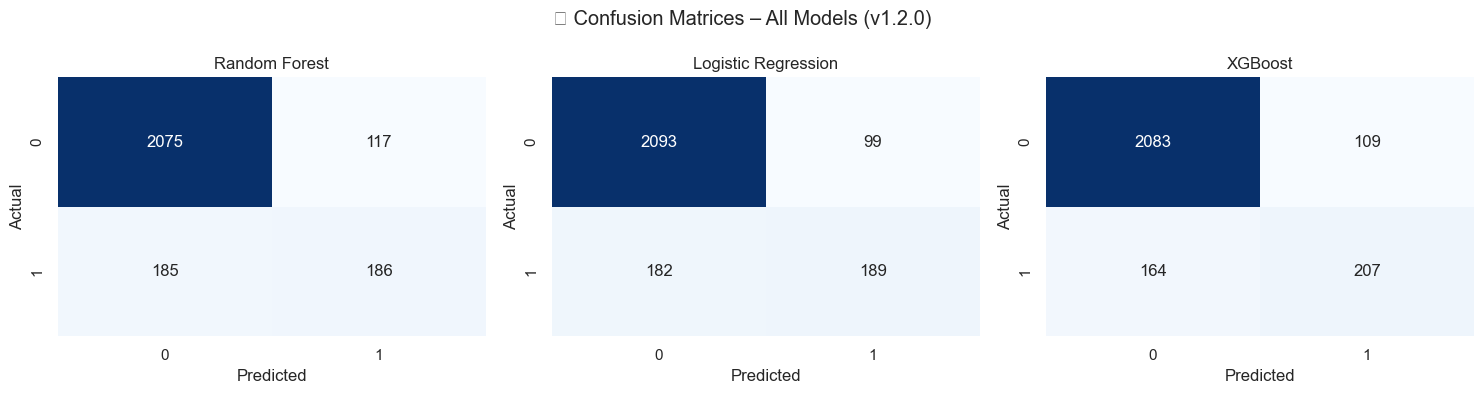

In [12]:
# -----------------------------------------------------------------------------
# 🔍 Confusion Matrix Comparison – v1.2.0
# Generates side-by-side confusion matrices for all models
# -----------------------------------------------------------------------------

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create horizontal grid for all 3 models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, model_data) in zip(axes, model_outputs.items()):
    cm = confusion_matrix(y_test, model_data["y_pred"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.suptitle("🔍 Confusion Matrices – All Models (v1.2.0)")
plt.tight_layout()

# Save plot to results folder
plt.savefig("../results/confusion_matrix_comparison_v1_2_0.png", dpi=300)
plt.show()


📊 1. Model Performance Bar Chart

C:\Users\Mantas\AppData\Local\Temp\ipykernel_26212\633303660.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Mantas\AppData\Local\Temp\ipykernel_26212\633303660.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig("../results/model_comparison_bar_v1_2_0.png", dpi=300)
c:\Users\Mantas\anaconda3\envs\portfolio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


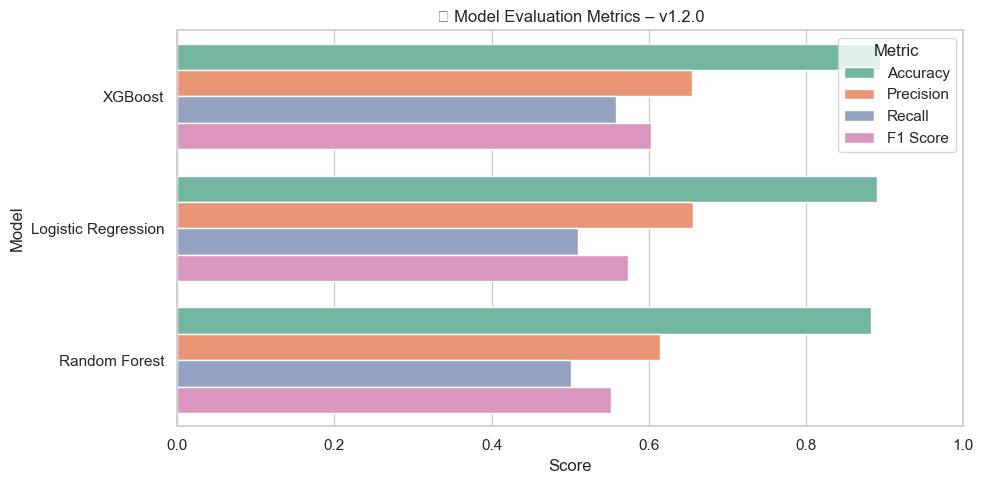

In [14]:
# -----------------------------------------------------------------------------
# 📊 Model Performance Bar Chart – Accuracy, Precision, Recall, F1
# -----------------------------------------------------------------------------

metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score"]
results_melted = results_df.melt(id_vars="Model", value_vars=metrics_to_plot)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=results_melted,
    x="value",
    y="Model",
    hue="variable",
    palette="Set2"
)
plt.title("📊 Model Evaluation Metrics – v1.2.0")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("../results/model_comparison_bar_v1_2_0.png", dpi=300)
plt.show()


🌟 2. Feature Importance Plots

C:\Users\Mantas\AppData\Local\Temp\ipykernel_26212\1554358146.py:8: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Mantas\AppData\Local\Temp\ipykernel_26212\1554358146.py:9: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.savefig("../results/feature_importance_rf_v1_2_0.png", dpi=300)
c:\Users\Mantas\anaconda3\envs\portfolio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


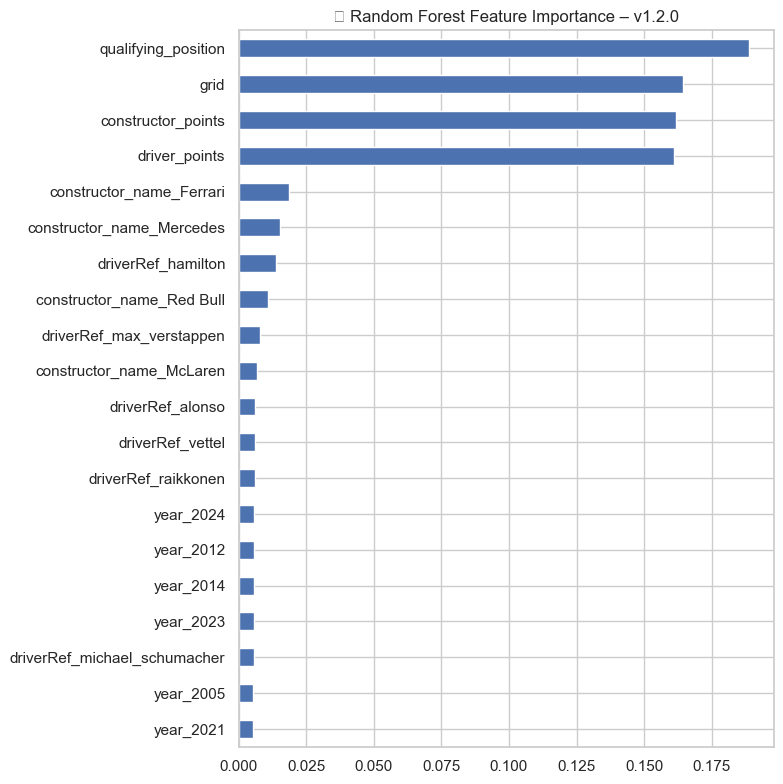

C:\Users\Mantas\AppData\Local\Temp\ipykernel_26212\1554358146.py:19: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Mantas\AppData\Local\Temp\ipykernel_26212\1554358146.py:20: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.savefig("../results/feature_importance_xgb_v1_2_0.png", dpi=300)
c:\Users\Mantas\anaconda3\envs\portfolio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


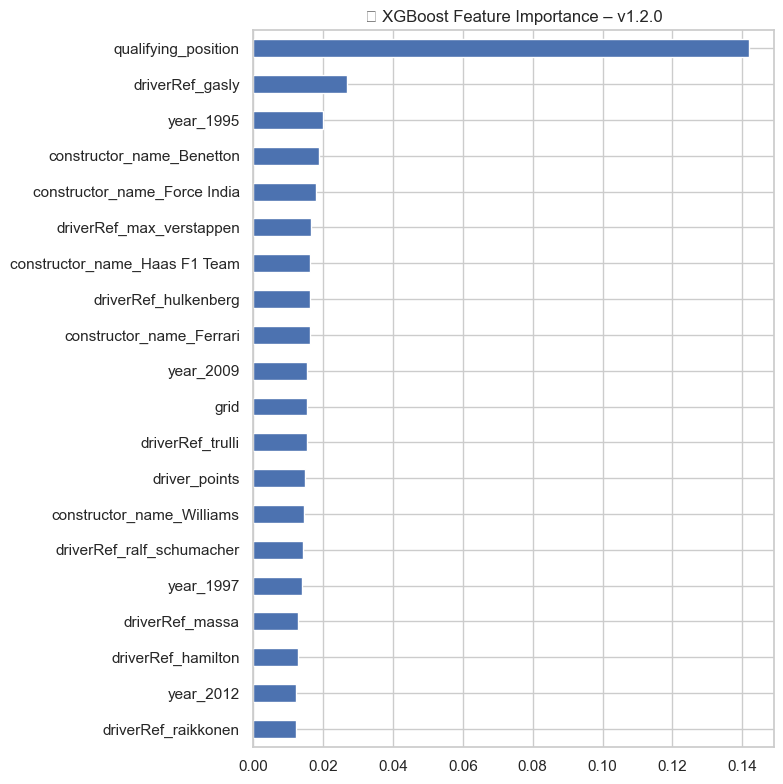

In [16]:
# -----------------------------------------------------------------------------
# 🌲 Feature Importance – Random Forest
# -----------------------------------------------------------------------------

importances_rf = pd.Series(rf.feature_importances_, index=X.columns)
importances_rf.sort_values(ascending=True).tail(20).plot(kind='barh', figsize=(8, 8))
plt.title("🔍 Random Forest Feature Importance – v1.2.0")
plt.tight_layout()
plt.savefig("../results/feature_importance_rf_v1_2_0.png", dpi=300)
plt.show()

# -----------------------------------------------------------------------------
# ⚡ Feature Importance – XGBoost
# -----------------------------------------------------------------------------

importances_xgb = pd.Series(xgb.feature_importances_, index=X.columns)
importances_xgb.sort_values(ascending=True).tail(20).plot(kind='barh', figsize=(8, 8))
plt.title("⚡ XGBoost Feature Importance – v1.2.0")
plt.tight_layout()
plt.savefig("../results/feature_importance_xgb_v1_2_0.png", dpi=300)
plt.show()
